# day 4-1

このノートブックの実行例は[こちら(HTML版)](../notebooks-sample/day-4-1.html)で確認できます

---

## 0. はじめに

ページ上部のメニューバーにある **Kernel** メニューをクリックし、プルダウンメニューから [**Change Kernel ...**] を選び、**gssm2024:Python** を選択してください。

<img src="images/change_kernel1.png" width="30%">

ノートブック上部の右隅に表示されたカーネル名が **gssm2024:Python** になっていることを確認してください。

<img src="images/change_kernel2.png" width="30%">

---

## 1. テキスト分析 (1)

### 1.0 事前準備 (定義済み関数の読み込み)

以下のセルを**修正せず**に実行してください

In [1]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

%matplotlib inline

### 1.1 データのダウンロード (前回ダウンロード済みのためスキップ)

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2023-2024.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2023/1~2024 GW明け | 本講義の全体を通して使用する |

In [2]:
# もし、再度ダウンロードが必要な場合は残りの行のコメントマーク「#」を除去して、このセルを再実行してください

# FILE_ID = "1EeCuDrfKdlsMxG9p3Ot7TIxfV9_f2smY"
# !gdown --id {FILE_ID}
# !unzip -o rakuten-1000-2023-2024.xlsx.zip

### 1.2 データの読み込み (DataFrame型)

In [3]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2023-2024.xlsx")
print(all_df.shape)
display(all_df.head())

(10000, 18)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別
0,A_レジャー,01_登別,80732,登別カルルス温泉 湯元オロフレ荘,彼のリクエストでカルルス温泉に宿泊させていただきました。北海道ラブ割利用でお得に宿泊できる分...,5,5,4,5,5.0,5.0,5.0,レジャー,恋人,45231,投稿者,na,na
1,A_レジャー,01_登別,149334,天然温泉 幸鐘の湯 ドーミーイン東室蘭（ドーミーイン・御宿野乃 ホテルズグループ）,室蘭方面の旅行の時には何度か宿泊しています。ドーミーインのサービスはとても良くて大好きです。...,4,5,5,2,5.0,5.0,5.0,レジャー,家族,45413,投稿者,na,na
2,A_レジャー,01_登別,109022,心のリゾート 海の別邸ふる川,もう一度行きたくなる宿でした。部屋もワンランクアップしていただき感謝しています。お風呂も最高...,4,3,5,5,4.0,5.0,3.0,レジャー,一人,45261,gaku0713,60代,男性
3,A_レジャー,01_登別,7506,ホテルニューバジェット室蘭,居心地良く過ごせました,4,4,4,4,4.0,4.0,3.0,レジャー,一人,45200,投稿者,na,na
4,A_レジャー,01_登別,37380,登別温泉 旅亭 花ゆら,事前カード精算で露天風呂付特別和洋室を予約しましたが別の和室に案内されました。すぐ違うことに...,1,2,4,2,2.0,4.0,3.0,レジャー,家族,45323,投稿者,na,na


### 1.3 単語の抽出

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [4]:
# 必要ライブラリのインポート
from collections import defaultdict
import MeCab

# mecab の初期化
tagger = MeCab.Tagger("-r ../tools/usr/local/etc/mecabrc --unk-feature 未知語")

# 単語頻度辞書の初期化
word_counts = defaultdict(lambda: 0)

# 抽出語情報リストの初期化
words = []

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ["湯畑"]

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, mecab で解析する
    node = tagger.parseToNode(row["コメント"].translate(HAN2ZEN))

    # 形態素ごとのループ
    while node:
        # 解析結果を要素ごとにバラす
        features = node.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}だ"
                postag = "形容動詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

        # 次の形態素へ
        node = node.next

# DataFrme 型に整える
columns = [
    "文書ID",
    # "単語ID",
    "表層",
    "品詞",
    "カテゴリー",
    "エリア",
    "dict_key",
]
docs_df = pd.DataFrame(words, columns=columns)

# DataFrame を表示する
print(docs_df.shape)
display(docs_df.head())

(158813, 6)


,文書ID,表層,品詞,カテゴリー,エリア,dict_key
0,1,リクエスト,名詞,A_レジャー,01_登別,"(リクエスト, 名詞)"
1,1,温泉,名詞,A_レジャー,01_登別,"(温泉, 名詞)"
2,1,ラブ,名詞,A_レジャー,01_登別,"(ラブ, 名詞)"
3,1,割,名詞,A_レジャー,01_登別,"(割, 名詞)"
4,1,得,名詞,A_レジャー,01_登別,"(得, 名詞)"


### 1.4 単語の出現回数 (Top 75)

単語の出現回数をカウントする

In [5]:
# 「文書-抽出語」 表から単語の出現回数をカウントする
word_list = []
for i, (k, v) in enumerate(sorted(word_counts.items(), key=lambda x:x[1], reverse=True)):
    word_list.append((i, k[0], v, k))

# DataFrame 型に整える
columns = [
    "単語ID",
    "表層",
    "出現頻度",
    "dict_key"
]
word_counts_df = pd.DataFrame(word_list, columns=columns)

# DataFrame を表示する
print(word_counts_df.shape)
display(word_counts_df.head(10))

(9058, 4)


,単語ID,表層,出現頻度,dict_key
0,0,部屋,6768,"(部屋, 名詞)"
1,1,良い,5397,"(良い, 形容詞)"
2,2,ホテル,3001,"(ホテル, 名詞)"
3,3,風呂,2692,"(風呂, 名詞)"
4,4,ない,2392,"(ない, 形容詞)"
5,5,美味しい,2294,"(美味しい, 形容詞)"
6,6,温泉,1854,"(温泉, 名詞)"
7,7,スタッフ,1677,"(スタッフ, 名詞)"
8,8,立地,1532,"(立地, 名詞)"
9,9,よい,1517,"(よい, 形容詞)"


単語IDを紐つける (出現回数 Top 150語のみ抽出する)

In [6]:
# 「単語出現回数」 表から出現回数Top 150語のみ抽出する
word_counts_150_df = word_counts_df[0:150]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_150_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_150_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# DataFrame を表示する
print(docs_150_df.shape)
display(docs_150_df)

(87334, 7)


,文書ID,単語ID,表層,品詞,カテゴリー,エリア,dict_key
0,1,6,温泉,名詞,A_レジャー,01_登別,"(温泉, 名詞)"
1,1,0,部屋,名詞,A_レジャー,01_登別,"(部屋, 名詞)"
2,1,66,プラン,名詞,A_レジャー,01_登別,"(プラン, 名詞)"
3,1,15,大変だ,形容動詞,A_レジャー,01_登別,"(大変だ, 形容動詞)"
4,1,6,温泉,名詞,A_レジャー,01_登別,"(温泉, 名詞)"
...,...,...,...,...,...,...,...
87329,10000,6,温泉,名詞,B_ビジネス,10_福岡,"(温泉, 名詞)"
87330,10000,6,温泉,名詞,B_ビジネス,10_福岡,"(温泉, 名詞)"
87331,10000,33,コンビニ,名詞,B_ビジネス,10_福岡,"(コンビニ, 名詞)"
87332,10000,2,ホテル,名詞,B_ビジネス,10_福岡,"(ホテル, 名詞)"


### 1.5 ワードクラウド

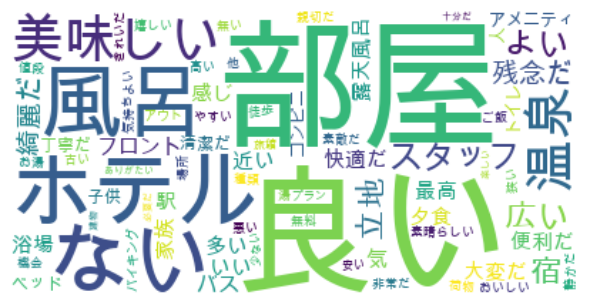

In [7]:
# 出現回数Top 75単語でワードクラウドを作成する
words = ' '.join(word_counts_df['表層'][0:75])
gssm_utils.plot_wordcloud(words)

### 1.6 「文書-抽出語」表の作成

「文書-抽出語」表を作成する (出現回数 Top 75語)

In [8]:
# 「単語出現回数」 表から出現回数Top 75語のみ抽出する
word_counts_75_df = word_counts_df[0:75]

# 「文書-抽出語」 表も出現回数Top 75語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_75_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_75_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_75_df = pd.crosstab(
    [
        docs_75_df['カテゴリー'], 
        docs_75_df['エリア'], 
        docs_75_df['文書ID']
    ], 
    docs_75_df['単語ID'], margins=False
)
cross_75_df.columns = word_counts_75_df["表層"]

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9677, 75)


表層                  部屋  良い  ホテル  風呂  ない  美味しい  温泉  スタッフ  立地  よい  ...  徒歩  プラン  \
カテゴリー  エリア   文書ID                                                ...            
A_レジャー 01_登別 1       1   0    0   0   0     1   5     1   0   0  ...   0    1   
             2       4   1    0   0   1     0   0     0   0   0  ...   0    0   
             3       1   0    0   1   0     0   0     0   0   0  ...   0    0   
             4       0   1    0   0   0     0   0     0   0   0  ...   0    0   
             5       5   0    0   1   2     0   0     0   0   0  ...   0    0   
...                 ..  ..  ...  ..  ..   ...  ..   ...  ..  ..  ...  ..  ...   
B_ビジネス 10_福岡 9996    2   0    1   0   0     0   0     0   0   0  ...   0    0   
             9997    1   0    0   2   0     0   0     0   1   0  ...   0    0   
             9998    0   0    1   0   0     0   0     0   0   0  ...   0    0   
             9999    0   0    0   0   0     0   0     0   0   0  ...   0    0   
             10000   0   1    1   0   0     0   2     0   0   0  ...   0    0   

表層                  少ない  安い  旅館  ありがたい  楽しい  建物  必要だ  十分だ  
カテゴリー  エリア   文書ID                                          
A_レジャー 01_登別 1        0   0   0      0    0   0    0    0  
             2        0   0   0      0    0   0    0    0  
             3        0   0   0      0    0   0    0    0  
             4        0   0   0      0    0   0    0    0  
             5        0   0   0      0    0   0    0    0  
...                 ...  ..  ..    ...  ...  ..  ...  ...  
B_ビジネス 10_福岡 9996     0   0   0      0    0   0    0    0  
             9997     0   0   0      0    0   0    0    0  
             9998     0   0   0      0    0   0    0    0  
             9999     0   0   0      0    0   0    0    0  
             10000    0   0   0      0    0   0    0    0  

[9677 rows x 75 columns]

「文書-抽出語」 表を {0,1} に変換する

In [9]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_75_df[cross_75_df > 0] = 1

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(9677, 75)


表層                  部屋  良い  ホテル  風呂  ない  美味しい  温泉  スタッフ  立地  よい  ...  徒歩  プラン  \
カテゴリー  エリア   文書ID                                                ...            
A_レジャー 01_登別 1       1   0    0   0   0     1   1     1   0   0  ...   0    1   
             2       1   1    0   0   1     0   0     0   0   0  ...   0    0   
             3       1   0    0   1   0     0   0     0   0   0  ...   0    0   
             4       0   1    0   0   0     0   0     0   0   0  ...   0    0   
             5       1   0    0   1   1     0   0     0   0   0  ...   0    0   
...                 ..  ..  ...  ..  ..   ...  ..   ...  ..  ..  ...  ..  ...   
B_ビジネス 10_福岡 9996    1   0    1   0   0     0   0     0   0   0  ...   0    0   
             9997    1   0    0   1   0     0   0     0   1   0  ...   0    0   
             9998    0   0    1   0   0     0   0     0   0   0  ...   0    0   
             9999    0   0    0   0   0     0   0     0   0   0  ...   0    0   
             10000   0   1    1   0   0     0   1     0   0   0  ...   0    0   

表層                  少ない  安い  旅館  ありがたい  楽しい  建物  必要だ  十分だ  
カテゴリー  エリア   文書ID                                          
A_レジャー 01_登別 1        0   0   0      0    0   0    0    0  
             2        0   0   0      0    0   0    0    0  
             3        0   0   0      0    0   0    0    0  
             4        0   0   0      0    0   0    0    0  
             5        0   0   0      0    0   0    0    0  
...                 ...  ..  ..    ...  ...  ..  ...  ...  
B_ビジネス 10_福岡 9996     0   0   0      0    0   0    0    0  
             9997     0   0   0      0    0   0    0    0  
             9998     0   0   0      0    0   0    0    0  
             9999     0   0   0      0    0   0    0    0  
             10000    0   0   0      0    0   0    0    0  

[9677 rows x 75 columns]

### 1.7 共起ネットワーク図

#### 1.7.1 共起度行列を作成する (抽出語-抽出語)

In [10]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

# 共起行列を作成する
X = cross_75_df.values
X = csc_matrix(X)
Xc = (X.T * X)
# 対角成分のみにする
Xc = np.triu(Xc.toarray())

# DataFrame 型に整える
cooccur_75_df = pd.DataFrame(Xc, columns=cross_75_df.columns, index=cross_75_df.columns)

# DataFrame を表示する
print(cooccur_75_df.shape)
display(cooccur_75_df.head())

(75, 75)


表層,部屋,良い,ホテル,風呂,ない,美味しい,温泉,スタッフ,立地,よい,...,徒歩,プラン,少ない,安い,旅館,ありがたい,楽しい,建物,必要だ,十分だ
表層,,,,,,,,,,,,,,,,,,,,,
部屋,4580,2023,1165,1313,1094,1112,769,791,780,714,...,192,207,209,179,148,200,153,184,180,191
良い,0,3839,922,1044,764,919,696,745,790,344,...,169,146,156,140,134,135,130,152,122,126
ホテル,0,0,2157,435,550,395,270,373,426,298,...,124,88,87,100,34,95,64,89,103,84
風呂,0,0,0,2150,521,612,411,362,303,348,...,84,84,113,65,88,86,85,80,82,86
ない,0,0,0,0,1746,392,321,344,303,326,...,91,110,118,96,70,83,46,78,118,77


#### 1.7.2 Jaccard 係数を求める (抽出語-抽出語)

In [11]:
# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_75_df = gssm_utils.jaccard_coef(cooccur_75_df, cross_75_df)

# DataFrame を表示する
print(jaccard_75_df.shape)
display(jaccard_75_df.head())

(75, 75)


表層,部屋,良い,ホテル,風呂,ない,美味しい,温泉,スタッフ,立地,よい,...,徒歩,プラン,少ない,安い,旅館,ありがたい,楽しい,建物,必要だ,十分だ
表層,,,,,,,,,,,,,,,,,,,,,
部屋,0.0,0.316291,0.209081,0.242385,0.209098,0.202329,0.147488,0.151823,0.147448,0.139426,...,0.040695,0.044174,0.044468,0.037892,0.031637,0.042553,0.032347,0.039132,0.038322,0.040917
良い,0.0,0.000000,0.181711,0.211122,0.158473,0.185732,0.153102,0.165006,0.174047,0.072421,...,0.042250,0.036445,0.038883,0.034809,0.033915,0.033549,0.032403,0.038067,0.030394,0.031563
ホテル,0.0,0.000000,0.000000,0.112345,0.164032,0.104222,0.082067,0.116381,0.132257,0.095697,...,0.052476,0.036944,0.036265,0.042017,0.014352,0.039882,0.026711,0.037489,0.043811,0.035714
風呂,0.0,0.000000,0.000000,0.000000,0.154370,0.171621,0.130808,0.112808,0.090800,0.113837,...,0.035058,0.035309,0.047760,0.026993,0.038128,0.036074,0.035895,0.033670,0.034672,0.036705
ない,0.0,0.000000,0.000000,0.000000,0.000000,0.115908,0.113508,0.121856,0.103307,0.121869,...,0.045844,0.056439,0.060296,0.048657,0.036420,0.041856,0.022966,0.039514,0.061299,0.039528


#### 1.7.3 プロットする

<Figure size 800x800 with 0 Axes>

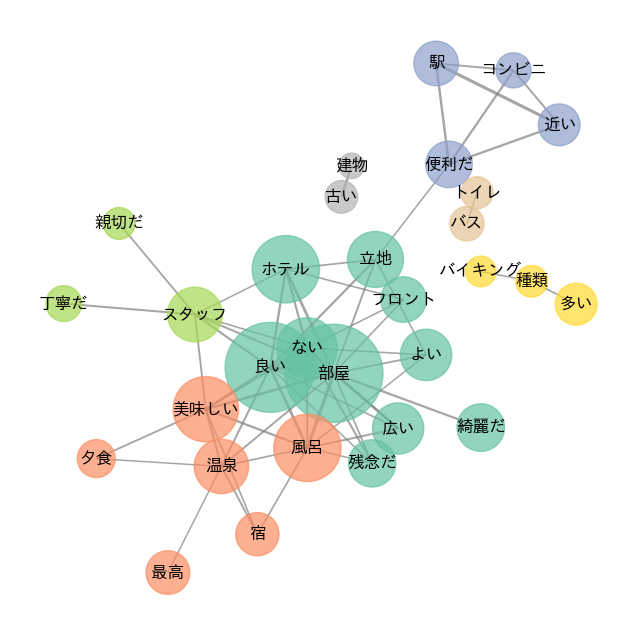

In [12]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 共起行列(Jaccard係数)で共起ネットワーク図を作成する
gssm_utils.plot_cooccur_network(jaccard_75_df, word_counts, np.sort(jaccard_75_df.values.reshape(-1))[::-1][60])

### 1.8 係り受けネットワーク図 

#### 1.8.1 係り受け行列を作成する

In [13]:
# チャンク(文節)から単語を取り出す
def get_words(tree, from_chunk, stopwords):

    # チャンク(文節)の開始位置を取得する
    beg = from_chunk.token_pos

    # チャンクの開始位置を取得する
    end = from_chunk.token_pos + from_chunk.token_size

    # 抽出語情報リストの初期化
    words = []

    # チャンク(文節)ごとのループ
    for i in range(beg, end):

        # チャンク中の形態素を取り出す
        token = tree.token(i)

        # 解析結果を要素ごとにバラす
        features = token.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}だ"
                postag = "形容動詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

    # 抽出語情報をリストを返却する
    return words


# 必要ライブラリのインポート
import CaboCha

# cabocha の初期化
cp = CaboCha.Parser("-r ../tools/usr/local/etc/cabocharc")

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ['*']  # 原形に 「'*'」 が出力された場合に除去するため

# 係り受けペア辞書の初期化
pair_counts = defaultdict(lambda: 0)
pairs = []

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, cabocha で解析する
    tree = cp.parse(row["コメント"].translate(HAN2ZEN))

    # 解析結果から空でないチャンク(文節)のリストを集める
    chunks = {}
    key = 0
    for i in range(tree.size()):
        tok = tree.token(i)
        if tok.chunk:
            chunks[key] = tok.chunk
            key += 1

    # 係り元と係り先の単語情報(原形と品詞)を集める
    for from_chunk in chunks.values():
        # 係り先がなければスキップ
        if from_chunk.link < 0:
            continue

        # 係り先のチャンク(文節)を取得する
        to_chunk = chunks[from_chunk.link]

        # 係り元の単語情報(原形と品詞)を取得する
        from_words = get_words(tree, from_chunk, stopwords)

        # 係り先の単語情報(原形と品詞)を取得する
        to_words = get_words(tree, to_chunk, stopwords)

    # 係り受けペアと頻度を収集する
    for f in from_words:
        for t in to_words:
            key = (f[0], t[0])
            pair_counts[key] += 1


# 係り受け行列を初期化する (共起行列と同じ形)
Xd = np.zeros(cooccur_75_df.shape)

# 係り受けペアを係り受け列に変換する
for (f,t), v in pair_counts.items():
    columns = list(cooccur_75_df.columns)
    if f in columns and t in columns:
        i = columns.index(f)
        j = columns.index(t)
        Xd[i,j] = v

# DataFrme 型に整える
dep_75_df = pd.DataFrame(Xd, columns=cooccur_75_df.columns, index=cooccur_75_df.columns)
print(dep_75_df.shape)
display(dep_75_df.head())

(75, 75)


表層,部屋,良い,ホテル,風呂,ない,美味しい,温泉,スタッフ,立地,よい,...,徒歩,プラン,少ない,安い,旅館,ありがたい,楽しい,建物,必要だ,十分だ
表層,,,,,,,,,,,,,,,,,,,,,
部屋,0.0,8.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
良い,3.0,2.0,24.0,0.0,3.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ホテル,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
風呂,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ない,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 1.8.2 条件付き確率を求める

In [14]:
# 係り受け行列の中身(numpy行列)を取り出す
Xc = dep_75_df.values

# 係り受け行列(条件付き確率)を初期化する (元の係り受け行列と同じ形)
Xd = np.zeros(Xc.shape)

# 係り元単語の出現頻度を取得する
word_counts = cooccur_75_df.sum(axis=0).values

# 係り受けペアごとのループ
for (f,t), v in pair_counts.items():
    columns = list(dep_75_df.columns)

    # 係り元と係り先の両方が列に含まれる
    if f in columns and t in columns:
        i = columns.index(f)
        j = columns.index(t)

        # 条件付き確率(係り受け頻度/係り先出現回数)を求める
        Xd[i,j] = v / word_counts[i]

# DataFrame 型に整える
dep_75_df = pd.DataFrame(Xd, columns=dep_75_df.columns, index=dep_75_df.columns)

# DataFrame を表示する
print(dep_75_df.shape)
display(dep_75_df.head())

(75, 75)


表層,部屋,良い,ホテル,風呂,ない,美味しい,温泉,スタッフ,立地,よい,...,徒歩,プラン,少ない,安い,旅館,ありがたい,楽しい,建物,必要だ,十分だ
表層,,,,,,,,,,,,,,,,,,,,,
部屋,0.000000,0.001747,0.000000,0.000218,0.000218,0.000218,0.000000,0.0,0.000000,0.000655,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
良い,0.000512,0.000341,0.004094,0.000000,0.000512,0.000341,0.000171,0.0,0.000171,0.000000,...,0.0,0.0,0.0,0.0,0.000171,0.0,0.0,0.0,0.000000,0.0
ホテル,0.000000,0.001649,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000236,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
風呂,0.000000,0.002428,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000809,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000202,0.0
ない,0.000214,0.000642,0.000214,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000214,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


#### 1.8.3 プロットする

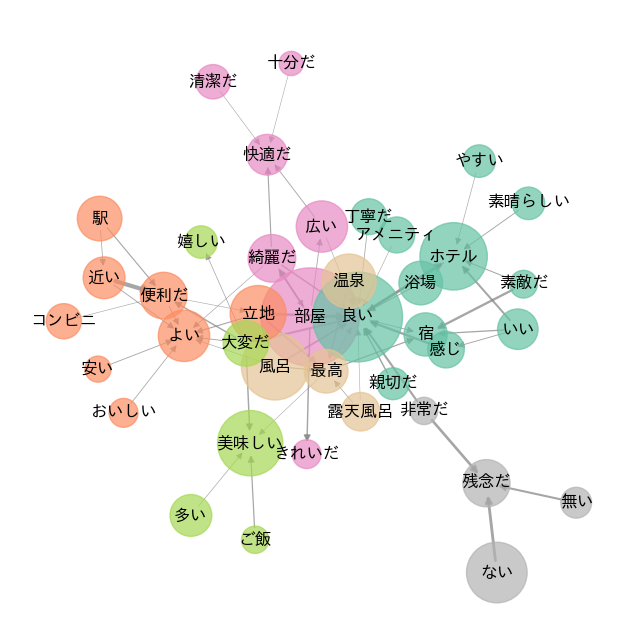

In [15]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 係り受け(条件付き確率)で共起ネットワーク図を作成する
gssm_utils.plot_dependency_network(dep_75_df, word_counts, np.sort(dep_75_df.values.reshape(-1))[::-1][60])

### 1.9 対応分析

「文書-抽出語」 表を確認する

In [16]:
# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df.head())

(9677, 75)


表層                 部屋  良い  ホテル  風呂  ない  美味しい  温泉  スタッフ  立地  よい  ...  徒歩  プラン  \
カテゴリー  エリア   文書ID                                               ...            
A_レジャー 01_登別 1      1   0    0   0   0     1   1     1   0   0  ...   0    1   
             2      1   1    0   0   1     0   0     0   0   0  ...   0    0   
             3      1   0    0   1   0     0   0     0   0   0  ...   0    0   
             4      0   1    0   0   0     0   0     0   0   0  ...   0    0   
             5      1   0    0   1   1     0   0     0   0   0  ...   0    0   

表層                 少ない  安い  旅館  ありがたい  楽しい  建物  必要だ  十分だ  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1       0   0   0      0    0   0    0    0  
             2       0   0   0      0    0   0    0    0  
             3       0   0   0      0    0   0    0    0  
             4       0   0   0      0    0   0    0    0  
             5       0   0   0      0    0   0    0    0  

[5 rows x 75 columns]

#### 1.9.1 「外部変数-抽出語」 クロス集計表を作成する

In [17]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_75_df = pd.concat(
    [
        cross_75_df.groupby(level='カテゴリー').sum(), 
        cross_75_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_75_df.shape)
display(aggregate_75_df)

(12, 75)


表層,部屋,良い,ホテル,風呂,ない,美味しい,温泉,スタッフ,立地,よい,...,徒歩,プラン,少ない,安い,旅館,ありがたい,楽しい,建物,必要だ,十分だ
A_レジャー,2367,2134,789,1498,957,1486,1290,916,548,677,...,135,168,207,128,236,144,234,204,104,138
B_ビジネス,2213,1705,1368,652,789,542,113,505,942,578,...,195,145,122,195,10,176,69,102,193,141
01_登別,433,422,173,296,193,260,271,149,47,111,...,12,40,45,26,30,23,40,27,16,24
02_草津,489,468,161,376,198,305,311,177,146,134,...,39,41,36,31,54,30,60,61,20,28
03_箱根,544,454,158,331,199,373,234,222,69,156,...,30,37,55,23,59,27,49,42,33,32
04_道後,408,380,228,190,157,177,231,130,184,135,...,31,24,38,31,20,33,29,31,16,24
05_湯布院,493,410,69,305,210,371,243,238,102,141,...,23,26,33,17,73,31,56,43,19,30
06_札幌,461,359,278,126,138,135,24,95,191,92,...,29,34,23,35,1,34,21,19,38,24
07_名古屋,430,337,267,123,155,104,30,99,164,130,...,40,32,29,41,3,42,9,31,29,32
08_東京,398,345,276,119,162,82,9,100,172,113,...,31,31,28,29,3,30,10,12,38,30


#### 1.9.2 対応分析プロットを作成する

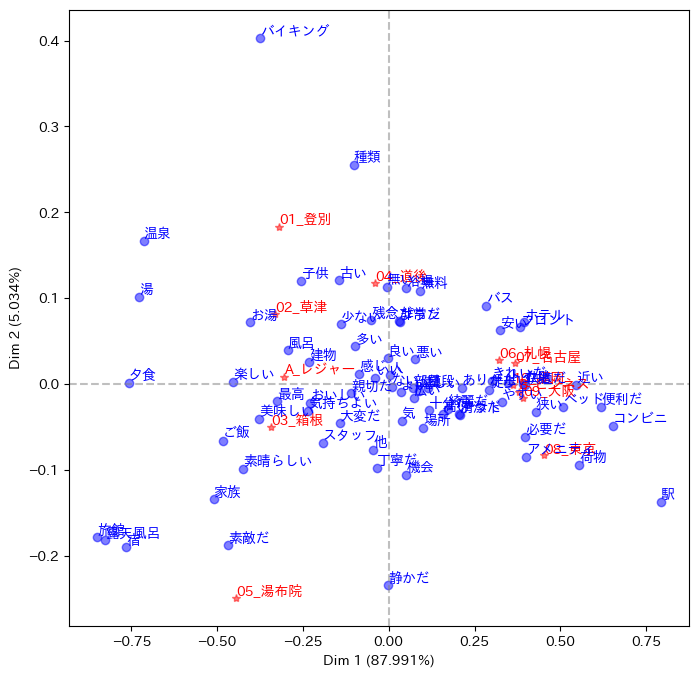

In [18]:
# 必要ライブラリのインポート
import mca

# ライブラリ mca による対応分析
ncols = aggregate_75_df.shape[1]
mca_ben = mca.MCA(aggregate_75_df, ncols=ncols, benzecri=False)

# 行方向および列方向の値を取り出す
row_coord = mca_ben.fs_r(N=2)
col_coord = mca_ben.fs_c(N=2)

# 固有値を求める
eigenvalues = mca_ben.L
total = np.sum(eigenvalues)
# 寄与率を求める
explained_inertia = 100 * eigenvalues / total

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord, row_labels, col_labels, explained_inertia)

### 1.10 トピックモデル

「文書-抽出語」 表を確認する

In [19]:
# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df.head())

(9677, 75)


表層                 部屋  良い  ホテル  風呂  ない  美味しい  温泉  スタッフ  立地  よい  ...  徒歩  プラン  \
カテゴリー  エリア   文書ID                                               ...            
A_レジャー 01_登別 1      1   0    0   0   0     1   1     1   0   0  ...   0    1   
             2      1   1    0   0   1     0   0     0   0   0  ...   0    0   
             3      1   0    0   1   0     0   0     0   0   0  ...   0    0   
             4      0   1    0   0   0     0   0     0   0   0  ...   0    0   
             5      1   0    0   1   1     0   0     0   0   0  ...   0    0   

表層                 少ない  安い  旅館  ありがたい  楽しい  建物  必要だ  十分だ  
カテゴリー  エリア   文書ID                                         
A_レジャー 01_登別 1       0   0   0      0    0   0    0    0  
             2       0   0   0      0    0   0    0    0  
             3       0   0   0      0    0   0    0    0  
             4       0   0   0      0    0   0    0    0  
             5       0   0   0      0    0   0    0    0  

[5 rows x 75 columns]

#### 1.10.1 トピックを抽出する (LDA)

In [20]:
# 必要ライブラリのインポート
from sklearn.decomposition import LatentDirichletAllocation as LDA

# ライブラリ LDA によるトピック抽出
lda = LDA(max_iter=25, learning_method='batch', random_state=0, n_jobs=-1, n_components=6)
lda.fit(cross_75_df.values)

# トピックごとに出現確率Top 20語を表示する
n_top_words = 20
feature_names = cross_75_df.columns
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic # {topic_idx+1}:", end=" ")
    for i in topic.argsort()[:-n_top_words-1:-1]:
        print(feature_names[i], end=" ")
    print()

Topic # 1: 浴場 スタッフ フロント 丁寧だ 部屋 良い 親切だ ホテル 綺麗だ 嬉しい 美味しい 気持ちよい ない 多い 広い アメニティ 楽しい 子供 ありがたい 快適だ 
Topic # 2: 立地 便利だ 良い 駅 近い ホテル コンビニ 部屋 徒歩 よい フロント ない 非常だ バス 場所 アメニティ 荷物 アウト 気 静かだ 
Topic # 3: 美味しい 温泉 良い 風呂 部屋 夕食 多い バイキング よい 種類 ない ご飯 感じ 残念だ お湯 宿 湯 露天風呂 いい 旅館 
Topic # 4: 最高 大変だ 良い 風呂 宿 部屋 素晴らしい 美味しい 露天風呂 家族 素敵だ スタッフ 温泉 夕食 楽しい ない ホテル 子供 嬉しい 残念だ 
Topic # 5: 部屋 良い ない ホテル 綺麗だ 風呂 残念だ いい 狭い トイレ ベッド 無い 気 悪い 値段 人 安い 広い 他 アメニティ 
Topic # 6: 部屋 広い 快適だ よい 清潔だ やすい きれいだ おいしい 機会 ホテル 十分だ 大変だ 静かだ 風呂 ありがたい 気持ちよい 場所 無料 アメニティ 荷物 


ChatGPT を使ってトピックを説明する

プロンプトの例:
> 以下はトピックとトピックごとの高確率ワードです. これを読んで各トピックの要約を日本語で作成してください.
> 
> Topic # 1	フロント ホテル 浴場 部屋 親切だ 良い …

結果の例:
- トピック1: ホテルのスタッフと設備
- トピック2: ホテルの立地と利便性
- トピック3: 温泉と食事の質
- トピック4: スタッフの対応と設備の質
- トピック5: 部屋の質と価格
- トピック6: 部屋の広さと快適さ

#### 1.10.2 トピックをワードクラウドで描画する

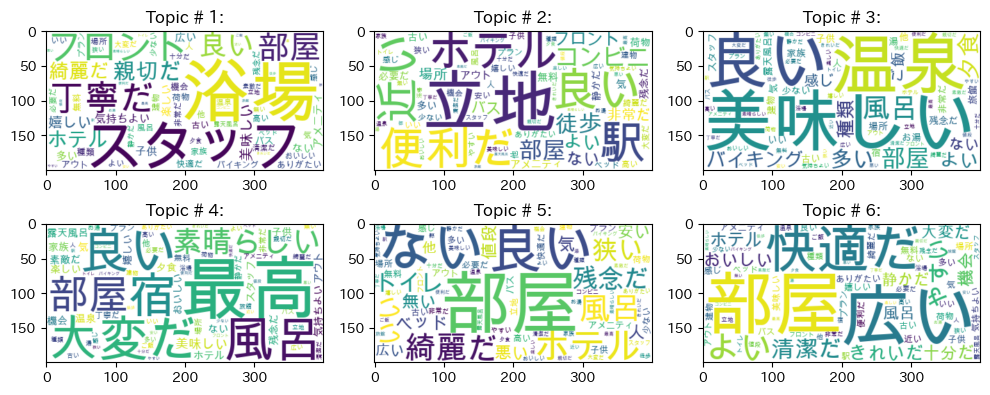

In [21]:
# トピックごとに出現確率Top 75語でワードクラウドを作成する
n_top_words = 75
gssm_utils.plot_topic_model(lda, feature_names, n_top_words)

#### 1.10.3 トピック分布をプロットする

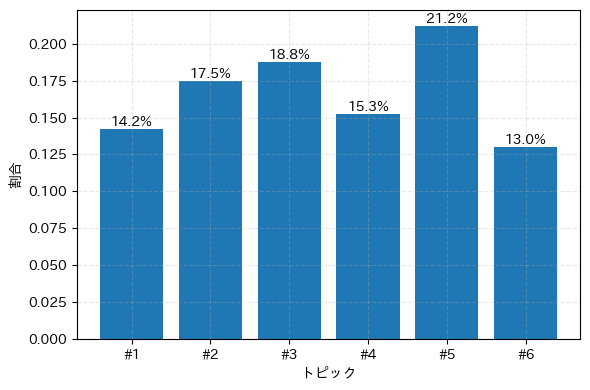

In [22]:
# 文書ごとのトピック比率を取得
doc_topic_distributions = lda.transform(cross_75_df.values)

# 文書全体のトピック比率を計算（平均を取る）
overall_topic_distribution = np.mean(doc_topic_distributions, axis=0)

gssm_utils.plot_topic_distribution(overall_topic_distribution)

---

### 1.11 外部変数の利用

#### 1.11.1 「文書-抽出語」表の作成

「文書-抽出語」表を作成する (出現回数 Top 150語)

In [23]:
# 「単語出現回数」 表から出現回数Top 150語のみ抽出する
word_counts_150_df = word_counts_df[0:150]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_150_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_150_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_150_df = pd.crosstab(
    [
        docs_150_df['カテゴリー'], 
        docs_150_df['エリア'], 
        docs_150_df['文書ID']
    ], 
    docs_150_df['単語ID'], margins=False
)
cross_150_df.columns = word_counts_150_df["表層"]

# DataFrame を表示する
print(cross_150_df.shape)
display(cross_150_df)

(9782, 150)


表層                  部屋  良い  ホテル  風呂  ない  美味しい  温泉  スタッフ  立地  よい  ...  キレイだ  \
カテゴリー  エリア   文書ID                                                ...         
A_レジャー 01_登別 1       1   0    0   0   0     1   5     1   0   0  ...     0   
             2       4   1    0   0   1     0   0     0   0   0  ...     0   
             3       1   0    0   1   0     0   0     0   0   0  ...     0   
             4       0   1    0   0   0     0   0     0   0   0  ...     0   
             5       5   0    0   1   2     0   0     0   0   0  ...     0   
...                 ..  ..  ...  ..  ..   ...  ..   ...  ..  ..  ...   ...   
B_ビジネス 10_福岡 9996    2   0    1   0   0     0   0     0   0   0  ...     0   
             9997    1   0    0   2   0     0   0     0   1   0  ...     0   
             9998    0   0    1   0   0     0   0     0   0   0  ...     0   
             9999    0   0    0   0   0     0   0     0   0   0  ...     0   
             10000   0   1    1   0   0     0   2     0   0   0  ...     0   

表層                  スペース  笑顔  小さい  次  布団  冷蔵庫  リピート  楽しみ  周り  
カテゴリー  エリア   文書ID                                             
A_レジャー 01_登別 1         0   0    0  0   0    0     0    0   0  
             2         0   0    0  0   0    0     0    0   0  
             3         0   0    0  0   0    0     0    0   0  
             4         0   0    0  0   0    0     0    0   0  
             5         0   0    0  0   0    0     0    0   0  
...                  ...  ..  ... ..  ..  ...   ...  ...  ..  
B_ビジネス 10_福岡 9996      0   0    0  0   0    0     0    0   1  
             9997      0   0    0  0   0    0     0    0   0  
             9998      0   0    0  0   0    0     0    0   0  
             9999      0   0    0  0   0    0     0    0   0  
             10000     0   0    0  0   0    0     0    0   0  

[9782 rows x 150 columns]

「文書-抽出語」表を {0,1} に変換する

In [24]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_150_df[cross_150_df > 0] = 1

# DataFrame を表示する
print(cross_150_df.shape)
display(cross_150_df)

(9782, 150)


表層                  部屋  良い  ホテル  風呂  ない  美味しい  温泉  スタッフ  立地  よい  ...  キレイだ  \
カテゴリー  エリア   文書ID                                                ...         
A_レジャー 01_登別 1       1   0    0   0   0     1   1     1   0   0  ...     0   
             2       1   1    0   0   1     0   0     0   0   0  ...     0   
             3       1   0    0   1   0     0   0     0   0   0  ...     0   
             4       0   1    0   0   0     0   0     0   0   0  ...     0   
             5       1   0    0   1   1     0   0     0   0   0  ...     0   
...                 ..  ..  ...  ..  ..   ...  ..   ...  ..  ..  ...   ...   
B_ビジネス 10_福岡 9996    1   0    1   0   0     0   0     0   0   0  ...     0   
             9997    1   0    0   1   0     0   0     0   1   0  ...     0   
             9998    0   0    1   0   0     0   0     0   0   0  ...     0   
             9999    0   0    0   0   0     0   0     0   0   0  ...     0   
             10000   0   1    1   0   0     0   1     0   0   0  ...     0   

表層                  スペース  笑顔  小さい  次  布団  冷蔵庫  リピート  楽しみ  周り  
カテゴリー  エリア   文書ID                                             
A_レジャー 01_登別 1         0   0    0  0   0    0     0    0   0  
             2         0   0    0  0   0    0     0    0   0  
             3         0   0    0  0   0    0     0    0   0  
             4         0   0    0  0   0    0     0    0   0  
             5         0   0    0  0   0    0     0    0   0  
...                  ...  ..  ... ..  ..  ...   ...  ...  ..  
B_ビジネス 10_福岡 9996      0   0    0  0   0    0     0    0   1  
             9997      0   0    0  0   0    0     0    0   0  
             9998      0   0    0  0   0    0     0    0   0  
             9999      0   0    0  0   0    0     0    0   0  
             10000     0   0    0  0   0    0     0    0   0  

[9782 rows x 150 columns]

#### 1.11.2 共起行列を作成する (外部変数-抽出語)

In [25]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_df = pd.concat(
    [
        cross_150_df.groupby(level='カテゴリー').sum(),
        cross_150_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_df.shape)
display(aggregate_df)

(12, 150)


表層,部屋,良い,ホテル,風呂,ない,美味しい,温泉,スタッフ,立地,よい,...,キレイだ,スペース,笑顔,小さい,次,布団,冷蔵庫,リピート,楽しみ,周り
A_レジャー,2367,2134,789,1498,957,1486,1290,916,548,677,...,63,61,127,102,91,115,81,105,121,74
B_ビジネス,2213,1705,1368,652,789,542,113,505,942,578,...,120,105,48,67,85,35,87,69,48,97
01_登別,433,422,173,296,193,260,271,149,47,111,...,8,15,19,21,14,28,18,14,35,12
02_草津,489,468,161,376,198,305,311,177,146,134,...,13,8,18,15,27,31,16,26,24,6
03_箱根,544,454,158,331,199,373,234,222,69,156,...,17,16,24,36,15,30,16,29,27,13
04_道後,408,380,228,190,157,177,231,130,184,135,...,19,14,22,21,13,11,9,9,11,8
05_湯布院,493,410,69,305,210,371,243,238,102,141,...,6,8,44,9,22,15,22,27,24,35
06_札幌,461,359,278,126,138,135,24,95,191,92,...,27,24,10,11,18,3,13,11,13,17
07_名古屋,430,337,267,123,155,104,30,99,164,130,...,33,24,14,19,14,5,15,15,6,16
08_東京,398,345,276,119,162,82,9,100,172,113,...,14,18,7,14,17,12,19,17,7,18


#### 1.11.3 Jaccard 係数を求める (外部変数-抽出語)

In [26]:
# 抽出語の出現回数を取得する
word_counts = cross_150_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('カテゴリー').values,
        all_df.value_counts('エリア').values
    ]
)

# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_attrs_df = gssm_utils.jaccard_attrs_coef(aggregate_df, attr_counts, word_counts, total=10000, conditional=False)

# DataFrame を表示する
print(jaccard_attrs_df.shape)
display(jaccard_attrs_df)

(12, 150)


表層,部屋,良い,ホテル,風呂,ない,美味しい,温泉,スタッフ,立地,よい,...,キレイだ,スペース,笑顔,小さい,次,布団,冷蔵庫,リピート,楽しみ,周り
A_レジャー,0.328157,0.318270,0.000000,0.265039,0.165314,0.268134,0.252298,0.166394,0.000000,0.121370,...,0.000000,0.000000,0.025158,0.020130,0.017896,0.022840,0.000000,0.020714,0.023970,0.000000
B_ビジネス,0.000000,0.000000,0.236310,0.000000,0.000000,0.000000,0.000000,0.000000,0.169791,0.000000,...,0.023701,0.020747,0.000000,0.000000,0.000000,0.000000,0.017123,0.000000,0.000000,0.019117
01_登別,0.000000,0.095540,0.000000,0.103714,0.075597,0.093931,0.127111,0.065581,0.000000,0.000000,...,0.000000,0.000000,0.016436,0.018293,0.000000,0.024955,0.015652,0.000000,0.030864,0.000000
02_草津,0.096052,0.107069,0.000000,0.135544,0.077708,0.112009,0.148662,0.078877,0.000000,0.063178,...,0.000000,0.000000,0.015557,0.000000,0.023499,0.027703,0.000000,0.022648,0.020961,0.000000
03_箱根,0.108022,0.103535,0.000000,0.117418,0.078131,0.140490,0.107884,0.100955,0.000000,0.074321,...,0.000000,0.000000,0.020851,0.031774,0.000000,0.026786,0.000000,0.025328,0.023643,0.000000
04_道後,0.000000,0.000000,0.077842,0.000000,0.000000,0.000000,0.106354,0.000000,0.079792,0.063679,...,0.016323,0.000000,0.019081,0.018293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
05_湯布院,0.096914,0.092572,0.000000,0.107206,0.082808,0.139631,0.112500,0.109024,0.000000,0.066698,...,0.000000,0.000000,0.038904,0.000000,0.019064,0.000000,0.019197,0.023540,0.020961,0.030810
06_札幌,0.090057,0.000000,0.096561,0.000000,0.000000,0.000000,0.000000,0.000000,0.083080,0.000000,...,0.023356,0.021016,0.000000,0.000000,0.015544,0.000000,0.000000,0.000000,0.000000,0.000000
07_名古屋,0.000000,0.000000,0.092388,0.000000,0.000000,0.000000,0.000000,0.000000,0.070507,0.061176,...,0.028696,0.021016,0.000000,0.016522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
08_東京,0.000000,0.000000,0.095800,0.000000,0.000000,0.000000,0.000000,0.000000,0.074202,0.000000,...,0.000000,0.015679,0.000000,0.000000,0.000000,0.000000,0.016536,0.000000,0.000000,0.015611


#### 1.11.4 特徴語ランキング

In [27]:
# 「カテゴリ」や「エリア」ごとに Jaccard 係数のTop 10語を抽出する
df_list = []
for index, row in jaccard_attrs_df.iterrows():
    df_list.append(row.iloc[np.argsort(row.values)[::-1][:10]].reset_index())

# 「カテゴリ」や「エリア」ごとの Jaccard 係数のTop 10 を横方向に連結した DetaFrame を作成する
ranking_df = pd.DataFrame(pd.concat(df_list, axis=1))
ranking_df.columns = np.array([c for pair in [[x,f"jaccard"] for x in jaccard_attrs_df.index] for c in pair], dtype='object')

# DataFrame を表示する
display(ranking_df)

,A_レジャー,jaccard,B_ビジネス,jaccard,01_登別,jaccard,02_草津,jaccard,03_箱根,jaccard,...,06_札幌,jaccard,07_名古屋,jaccard,08_東京,jaccard,09_大阪,jaccard,10_福岡,jaccard
0,部屋,0.328157,ホテル,0.236310,温泉,0.127111,温泉,0.148662,美味しい,0.140490,...,ホテル,0.096561,ホテル,0.092388,駅,0.121037,駅,0.092697,立地,0.102258
1,良い,0.318270,立地,0.169791,風呂,0.103714,風呂,0.135544,露天風呂,0.132890,...,部屋,0.090057,駅,0.084774,便利だ,0.097297,ホテル,0.090501,ホテル,0.099234
2,美味しい,0.268134,駅,0.153921,良い,0.095540,宿,0.117160,風呂,0.117418,...,立地,0.083080,便利だ,0.072372,ホテル,0.095800,部屋,0.089631,部屋,0.090909
3,風呂,0.265039,便利だ,0.145952,美味しい,0.093931,美味しい,0.112009,部屋,0.108022,...,浴場,0.074408,立地,0.070507,コンビニ,0.082481,便利だ,0.083823,駅,0.085379
4,温泉,0.252298,フロント,0.115707,バイキング,0.084771,良い,0.107069,温泉,0.107884,...,便利だ,0.071806,近い,0.070175,近い,0.080283,立地,0.079792,便利だ,0.084402
5,スタッフ,0.166394,近い,0.112383,夕食,0.084353,部屋,0.096052,宿,0.107331,...,快適だ,0.065593,快適だ,0.069420,立地,0.074202,フロント,0.073434,ない,0.071401
6,ない,0.165314,綺麗だ,0.104125,種類,0.078832,湯,0.094293,良い,0.103535,...,広い,0.063860,フロント,0.066524,フロント,0.067669,近い,0.073314,綺麗だ,0.067352
7,宿,0.159968,快適だ,0.095608,ない,0.075597,最高,0.084139,スタッフ,0.100955,...,駅,0.061681,よい,0.061176,アメニティ,0.063199,綺麗だ,0.063525,フロント,0.064810
8,露天風呂,0.132394,コンビニ,0.087794,最高,0.071951,夕食,0.081567,夕食,0.097068,...,フロント,0.060832,コンビニ,0.060788,綺麗だ,0.057026,快適だ,0.060534,近い,0.063953
9,夕食,0.124876,アメニティ,0.076083,残念だ,0.071800,スタッフ,0.078877,残念だ,0.078534,...,近い,0.056582,綺麗だ,0.059184,快適だ,0.056147,コンビニ,0.057961,バス,0.058943


#### 1.11.5 ワードクラウド (カテゴリーごと)

A_レジャー


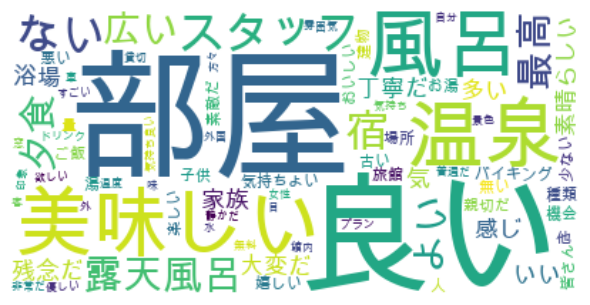

B_ビジネス


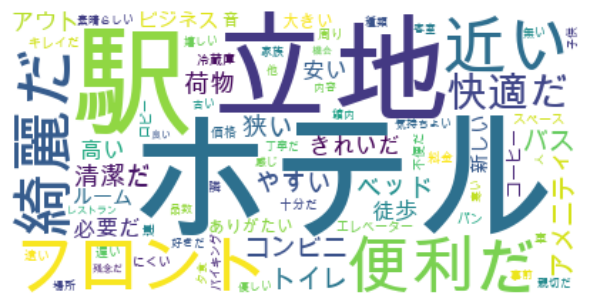

In [28]:
for name, group in cross_150_df.groupby(level='カテゴリー'):
    print(name)

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # プロットする
    gssm_utils.plot_wordcloud(" ".join(group_cross_df.columns))

#### 1.11.6 共起ネットワーク図 (カテゴリーごと)

A_レジャー


<Figure size 800x800 with 0 Axes>

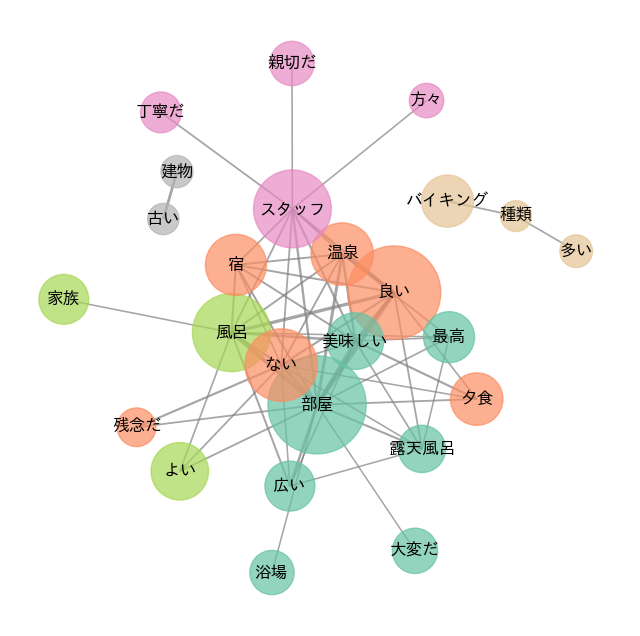

B_ビジネス


<Figure size 800x800 with 0 Axes>

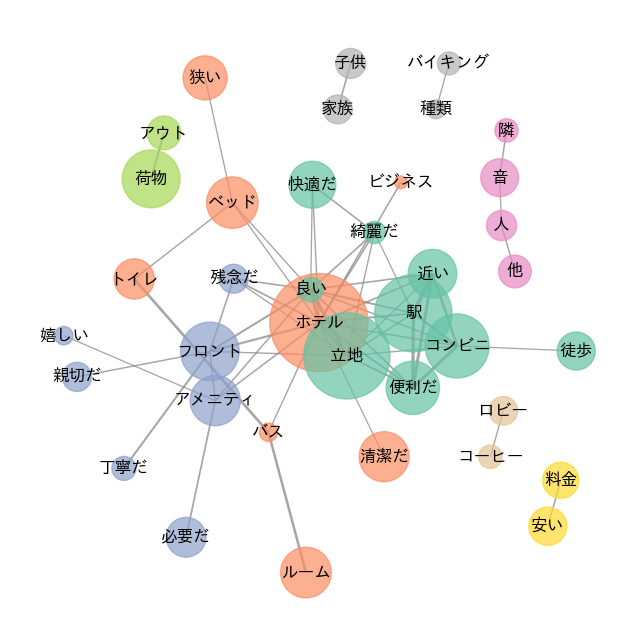

In [29]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

for name, group in cross_150_df.groupby(level='カテゴリー'):
    print(name)

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # 共起行列を作成する
    X = group_cross_df.values
    X = csc_matrix(X)
    Xc = (X.T * X)
    Xc = np.triu(Xc.toarray())

    # 共起行列を DataFrame に整える
    group_cooccur_df = pd.DataFrame(Xc, columns=group_cross_df.columns, index=group_cross_df.columns)

    # 共起行列の中身を Jaccard 係数に入れ替える
    group_jaccard_df = gssm_utils.jaccard_coef(group_cooccur_df, group_cross_df)

    # 抽出語の出現回数を取得する
    word_counts = group.sum(axis=0).values

    # プロットする
    gssm_utils.plot_cooccur_network(group_jaccard_df, word_counts, np.sort(group_jaccard_df.values.reshape(-1))[::-1][60])

#### 1.11.7 トピック分布 (カテゴリーごと)

#### 1.11.7.1 文書全体からトピックを抽出する (LDA)

In [30]:
# 必要ライブラリのインポート
from sklearn.decomposition import LatentDirichletAllocation as LDA

# ライブラリ LDA によるトピック抽出
lda = LDA(max_iter=25, learning_method='batch', random_state=0, n_jobs=-1, n_components=6)
lda.fit(cross_150_df.values)

# トピックごとに出現確率Top 20語を表示する
n_top_words = 20
feature_names = cross_150_df.columns
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic # {topic_idx+1}:", end=" ")
    for i in topic.argsort()[:-n_top_words-1:-1]:
        print(feature_names[i], end=" ")
    print()

Topic # 1: 部屋 ホテル 快適だ 浴場 ない フロント 良い きれいだ 広い 機会 新しい 綺麗だ やすい アメニティ よい 清潔だ ルーム 狭い いい ベッド 
Topic # 2: 温泉 美味しい 風呂 部屋 良い 宿 露天風呂 よい ない 最高 お湯 夕食 湯 古い いい 家族 残念だ 感じ ご飯 建物 
Topic # 3: 部屋 良い 立地 広い 綺麗だ 風呂 ホテル 値段 最高 安い トイレ 満足だ 古い 狭い 価格 ベッド 美味しい 残念だ よい 気 
Topic # 4: スタッフ 大変だ 良い 部屋 美味しい 素晴らしい 親切だ 丁寧だ 温泉 素敵だ 風呂 宿 方々 気持ちよい 皆さん 楽しい 家族 最高 優しい フロント 
Topic # 5: 多い ない 部屋 良い 種類 ホテル 残念だ 悪い 風呂 美味しい 少ない 人 バイキング 浴場 フロント タオル 豊富だ 無料 客 スタッフ 
Topic # 6: 便利だ 駅 近い コンビニ ホテル 立地 良い 部屋 徒歩 ビジネス バス よい 大変だ 遠い ない 場所 気 やすい 荷物 フロント 


#### 1.11.7.2 トピックをワードクラウドで描画する

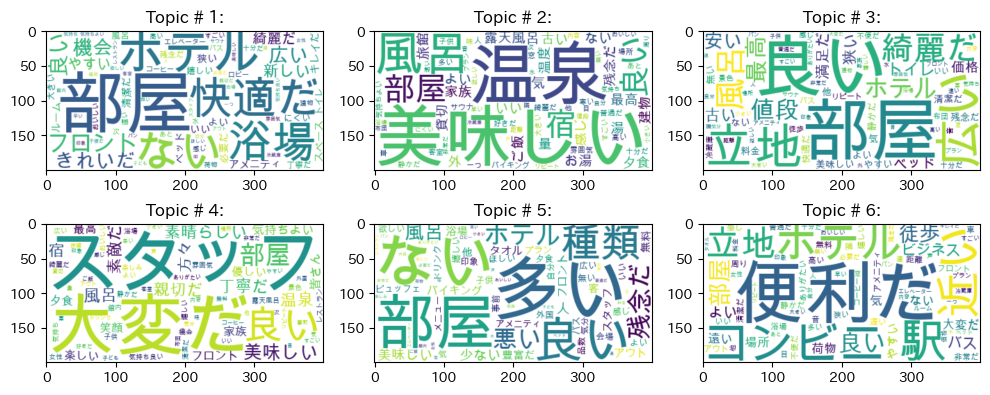

In [31]:
# トピックごとに出現確率Top 75語でワードクラウドを作成する
n_top_words = 75
gssm_utils.plot_topic_model(lda, feature_names, n_top_words)

#### 1.11.7.3 トピック分布をプロットする

A_レジャー


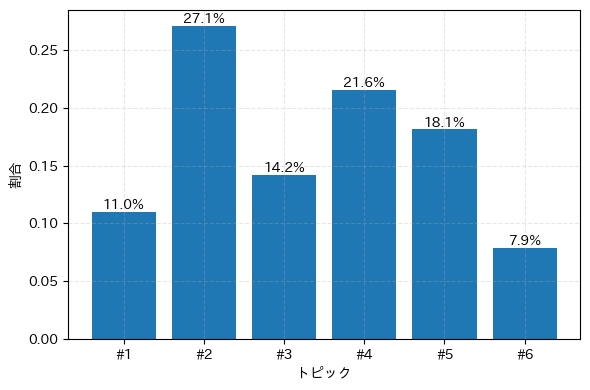

B_ビジネス


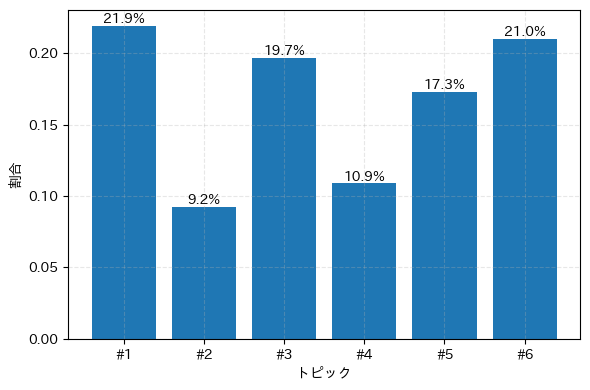

In [32]:
for name, group in cross_150_df.groupby(level='カテゴリー'):
    print(name)

    # 文書ごとのトピック比率を取得
    doc_topic_distributions = lda.transform(group.values)

    # 文書全体のトピック比率を計算（平均を取る）
    overall_topic_distribution = np.mean(doc_topic_distributions, axis=0)

    gssm_utils.plot_topic_distribution(overall_topic_distribution)

#### 1.11.8 本文の参照 (カテゴリーごと)

「夕食」「残念」という単語が含まれている口コミを表示する

In [33]:
for name, group in docs_df.groupby('カテゴリー'):
    print(name)

    search_index = all_df['コメント'].str.contains('夕食') & all_df['コメント'].str.contains('残念')

    display(all_df[search_index])

A_レジャー


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別
70,A_レジャー,01_登別,29995,ゆとりろ洞爺湖,会席料理の宿を探していて見つけました。お料理大変おいしかったです。オールインクルーシブも気兼...,4,3,4,5,4.0,4.0,4.0,レジャー,家族,45139,投稿者,na,na
155,A_レジャー,01_登別,5499,室蘭プリンスホテル,シンプルで静かで素敵なホテルでした。趣のある商店街の一角にあり、歩いてすぐのところにコンビニ...,4,4,5,4,4.0,NaN,3.0,レジャー,家族,45200,Rikappa☆,40代,女性
166,A_レジャー,01_登別,37379,登別温泉 名湯の宿 パークホテル雅亭,2週間後の宿泊 温泉地のホテルでなるべく価格を抑えて朝夕食事付き で探し、古いのかな、とおも...,5,5,5,5,5.0,5.0,5.0,レジャー,家族,45200,にゃんこのら,50代,女性
218,A_レジャー,01_登別,29995,ゆとりろ洞爺湖,愛犬と足の悪い姉と夫の３人と一匹で、伺いました。お部屋は、古い感じですが、和室で皆寛ぐ事が出...,4,5,3,3,3.0,2.0,5.0,レジャー,家族,45231,投稿者,na,na
244,A_レジャー,01_登別,162792,虎杖浜温泉ホテル,お食事は夕食朝食ともに、素晴らしかったです。お部屋とお風呂にブラシがなく？と思って帰りに気が...,4,4,4,2,3.0,3.0,5.0,レジャー,家族,44986,投稿者,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6417,B_ビジネス,07_名古屋,10897,ホテル メルパルク名古屋,館内レストランで夕食を休止していたのでちかくの食べれるところをスタッフに尋ねたら面倒くさい感...,4,3,4,4,3.0,4.0,4.0,レジャー,友達,45261,投稿者,na,na
8998,B_ビジネス,09_大阪,164935,アートホテル大阪ベイタワー,家族3人での利用でした。空庭温泉目的だったので、とても近くてよかった。ホテル下には、スーパー...,3,2,5,3,3.0,NaN,NaN,レジャー,家族,45078,NOBU2345,40代,女性
9689,B_ビジネス,10_福岡,182181,ホテルオリエンタルエクスプレス福岡中洲川端,８月に２泊しましたが、使い捨てスリッパの袋が縦に破れていたり、トイレ・バスルームは下水臭く、...,1,1,3,1,3.0,2.0,NaN,レジャー,家族,45139,投稿者,na,na
9704,B_ビジネス,10_福岡,12562,ザ・レジデンシャルスイート・福岡,久しぶりにザ・レジデンシャルスィート福岡を利用しました。PayPayドームを利用する際に、私...,4,4,5,5,4.0,3.0,3.0,レジャー,一人,45139,ゆっきー２５１５,50代,男性


B_ビジネス


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別
70,A_レジャー,01_登別,29995,ゆとりろ洞爺湖,会席料理の宿を探していて見つけました。お料理大変おいしかったです。オールインクルーシブも気兼...,4,3,4,5,4.0,4.0,4.0,レジャー,家族,45139,投稿者,na,na
155,A_レジャー,01_登別,5499,室蘭プリンスホテル,シンプルで静かで素敵なホテルでした。趣のある商店街の一角にあり、歩いてすぐのところにコンビニ...,4,4,5,4,4.0,NaN,3.0,レジャー,家族,45200,Rikappa☆,40代,女性
166,A_レジャー,01_登別,37379,登別温泉 名湯の宿 パークホテル雅亭,2週間後の宿泊 温泉地のホテルでなるべく価格を抑えて朝夕食事付き で探し、古いのかな、とおも...,5,5,5,5,5.0,5.0,5.0,レジャー,家族,45200,にゃんこのら,50代,女性
218,A_レジャー,01_登別,29995,ゆとりろ洞爺湖,愛犬と足の悪い姉と夫の３人と一匹で、伺いました。お部屋は、古い感じですが、和室で皆寛ぐ事が出...,4,5,3,3,3.0,2.0,5.0,レジャー,家族,45231,投稿者,na,na
244,A_レジャー,01_登別,162792,虎杖浜温泉ホテル,お食事は夕食朝食ともに、素晴らしかったです。お部屋とお風呂にブラシがなく？と思って帰りに気が...,4,4,4,2,3.0,3.0,5.0,レジャー,家族,44986,投稿者,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6417,B_ビジネス,07_名古屋,10897,ホテル メルパルク名古屋,館内レストランで夕食を休止していたのでちかくの食べれるところをスタッフに尋ねたら面倒くさい感...,4,3,4,4,3.0,4.0,4.0,レジャー,友達,45261,投稿者,na,na
8998,B_ビジネス,09_大阪,164935,アートホテル大阪ベイタワー,家族3人での利用でした。空庭温泉目的だったので、とても近くてよかった。ホテル下には、スーパー...,3,2,5,3,3.0,NaN,NaN,レジャー,家族,45078,NOBU2345,40代,女性
9689,B_ビジネス,10_福岡,182181,ホテルオリエンタルエクスプレス福岡中洲川端,８月に２泊しましたが、使い捨てスリッパの袋が縦に破れていたり、トイレ・バスルームは下水臭く、...,1,1,3,1,3.0,2.0,NaN,レジャー,家族,45139,投稿者,na,na
9704,B_ビジネス,10_福岡,12562,ザ・レジデンシャルスイート・福岡,久しぶりにザ・レジデンシャルスィート福岡を利用しました。PayPayドームを利用する際に、私...,4,4,5,5,4.0,3.0,3.0,レジャー,一人,45139,ゆっきー２５１５,50代,男性


---

## 【演習】 外部変数を利用したエリアごとの作図

注意: 以下の演習は上のセルを全て実行してから続けて実施してください

#### 2.1 【演習】 ワードクラウド (エリアごと)

In [34]:
# ToDo: 1.11.5 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する

#### 2.2 【演習】 共起ネットワーク図 (エリアごと)

In [35]:
# ToDo: 1.11.6 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する

#### 2.3 【演習】 トピック分布 (エリアごと)

In [36]:
# ToDo: 1.11.7.2 のセル中のコードをコピーして貼り付け,そのまま実行する

In [37]:
# ToDo: 1.11.7.3 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する

#### 2.4 【演習】 本文の参照 (エリアごと)

In [38]:
# ToDo: 1.11.8 のセル中のコードをコピーして貼り付け,「カテゴリー」を「エリア」に変更する